# **CNN Lab**


## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>


<p style='color: blue'>Note: Training CNNs takes time, you should expect waiting time to be around 10 ~ 30 mins after running a cell that trains a CNN.</p>

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.


In [44]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [45]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [36]:
## Each image is a 32 x 32 x 3 numpy array
x_train[522].shape

(32, 32, 3)

[9]


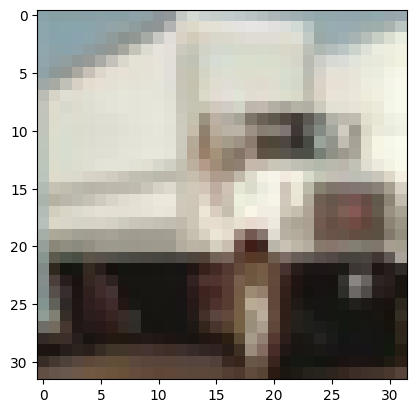

In [46]:
## Let's look at one of the images

print(y_train[444])
plt.imshow(x_train[444]);

In [5]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [7]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.


In [8]:
# Let's build a CNN using Keras' Sequential capabilities

model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same',
                 input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        2432      
                                                                 
 activation (Activation)     (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 activation_1 (Activation)   (None, 6, 6, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                        

We still have 181K parameters, even though this is a "small" model.


In [12]:
batch_size = 32


# Let's train the model using RMSprop
model_1.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=5,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/5
1563/1563 [==============================] - 39s 24ms/step - loss: 1.6603 - accuracy: 0.3942 - val_loss: 1.3967 - val_accuracy: 0.5026
Epoch 2/5
1563/1563 [==============================] - 38s 24ms/step - loss: 1.4147 - accuracy: 0.4878 - val_loss: 1.2757 - val_accuracy: 0.5514
Epoch 3/5
1563/1563 [==============================] - 39s 25ms/step - loss: 1.3333 - accuracy: 0.5207 - val_loss: 1.2407 - val_accuracy: 0.5571
Epoch 4/5
1563/1563 [==============================] - 37s 24ms/step - loss: 1.2737 - accuracy: 0.5433 - val_loss: 1.1724 - val_accuracy: 0.5823
Epoch 5/5
1563/1563 [==============================] - 37s 23ms/step - loss: 1.2324 - accuracy: 0.5602 - val_loss: 1.1444 - val_accuracy: 0.6019


### Exercise
Our previous model had the structure:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. Build a more complicated model with the following pattern:
- Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

- Use strides of 1 for all convolutional layers.

2. How many parameters does your model have?  How does that compare to the previous model?

3. Train it for 5 epochs.  What do you notice about the training time, loss and accuracy numbers (on both the training and validation sets)?

5. Try different structures and run times, and see how accurate your model can be.


In [13]:
# Let's build a CNN using Keras' Sequential capabilities

model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model_2.add(Activation('relu'))
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

In [14]:
## Check number of parameters

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_4 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_5 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 15, 15, 32)        0         
                                                      

In [15]:
# initiate RMSprop optimizer
opt_2 = keras.optimizers.RMSprop(lr=0.0005)

# Let's train the model using RMSprop
model_2.compile(loss='categorical_crossentropy',
              optimizer=opt_2,
              metrics=['accuracy'])

In [16]:
model_2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=5,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/5
1563/1563 [==============================] - 298s 190ms/step - loss: 1.5380 - accuracy: 0.4452 - val_loss: 1.2100 - val_accuracy: 0.5637
Epoch 2/5
1563/1563 [==============================] - 301s 193ms/step - loss: 1.1185 - accuracy: 0.6080 - val_loss: 1.0736 - val_accuracy: 0.6319
Epoch 3/5
1563/1563 [==============================] - 293s 188ms/step - loss: 0.9751 - accuracy: 0.6610 - val_loss: 0.9161 - val_accuracy: 0.6918
Epoch 4/5
1563/1563 [==============================] - 303s 194ms/step - loss: 0.9133 - accuracy: 0.6878 - val_loss: 0.8963 - val_accuracy: 0.6887
Epoch 5/5
1563/1563 [==============================] - 297s 190ms/step - loss: 0.8791 - accuracy: 0.7009 - val_loss: 0.8917 - val_accuracy: 0.6950


In [17]:
def plot_activations_multilayer(num_layers, images_per_row, classifier, activations):
    layer_names = []
    for layer in classifier.layers[:num_layers]:
        layer_names.append(layer.name + ' layer')  # Names of the layers, so you can have them as part of your plot
    for layer_name, layer_activation in zip(layer_names, activations):  # Displays the feature maps
        n_features = layer_activation.shape[-1]  # Number of features in the feature map
        size = layer_activation.shape[1]  # The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :,
                                                 col * images_per_row + row]
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 2. / size
        plt.figure(figsize=(scale*display_grid.shape[1],
                            scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

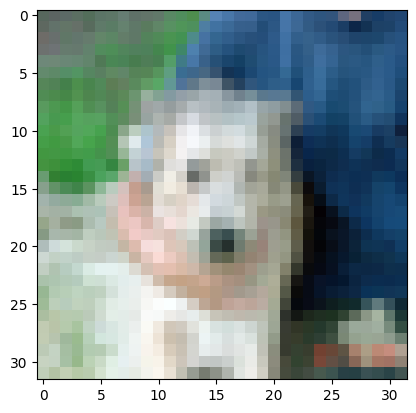

In [51]:
# display the sample image
# img_tensor = np.array(x_test[444], dtype='int').reshape(x_train.shape[1:])
img_tensor = x_test[444]
plt.imshow(img_tensor)

In [52]:
img_tensor = np.expand_dims(img_tensor, axis=0)
y = model_2.predict(img_tensor)
print(f"The predicted output of the sample image has a shape of {y.shape}.")

1/1 [==============================] - 0s 96ms/step
The predicted output of the sample image has a shape of (1, 10).


1/1 [==============================] - 0s 114ms/step


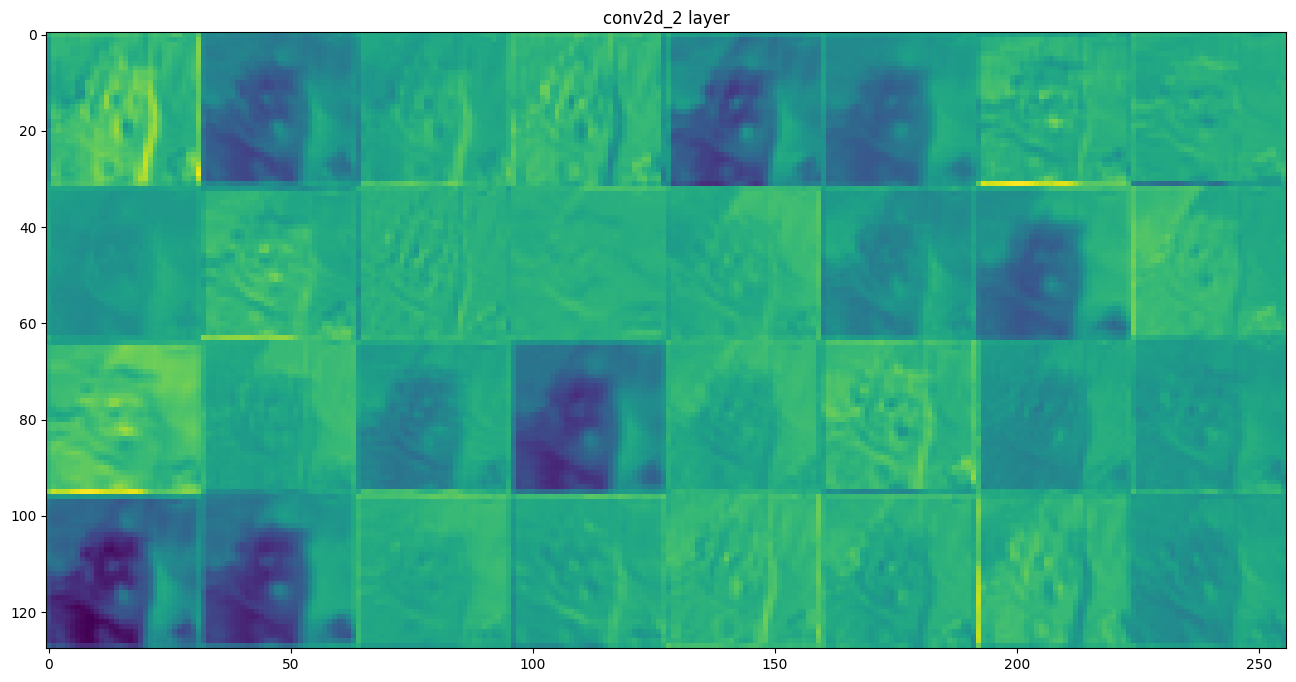

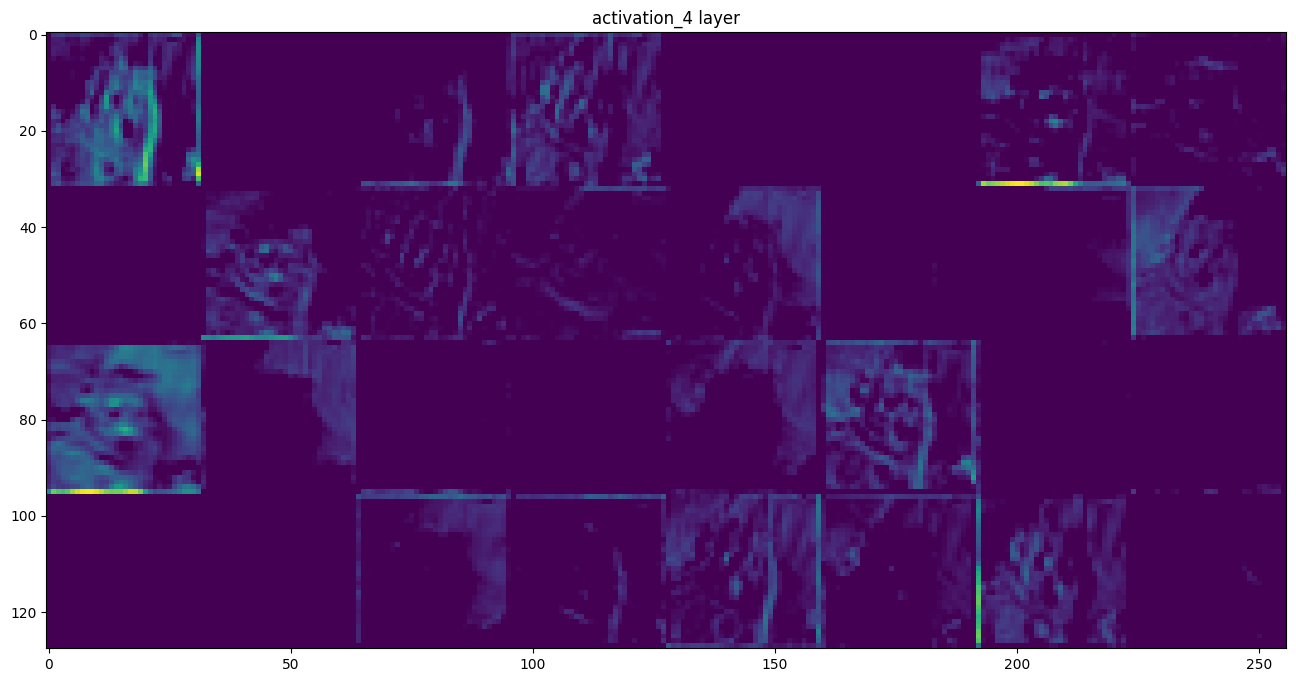

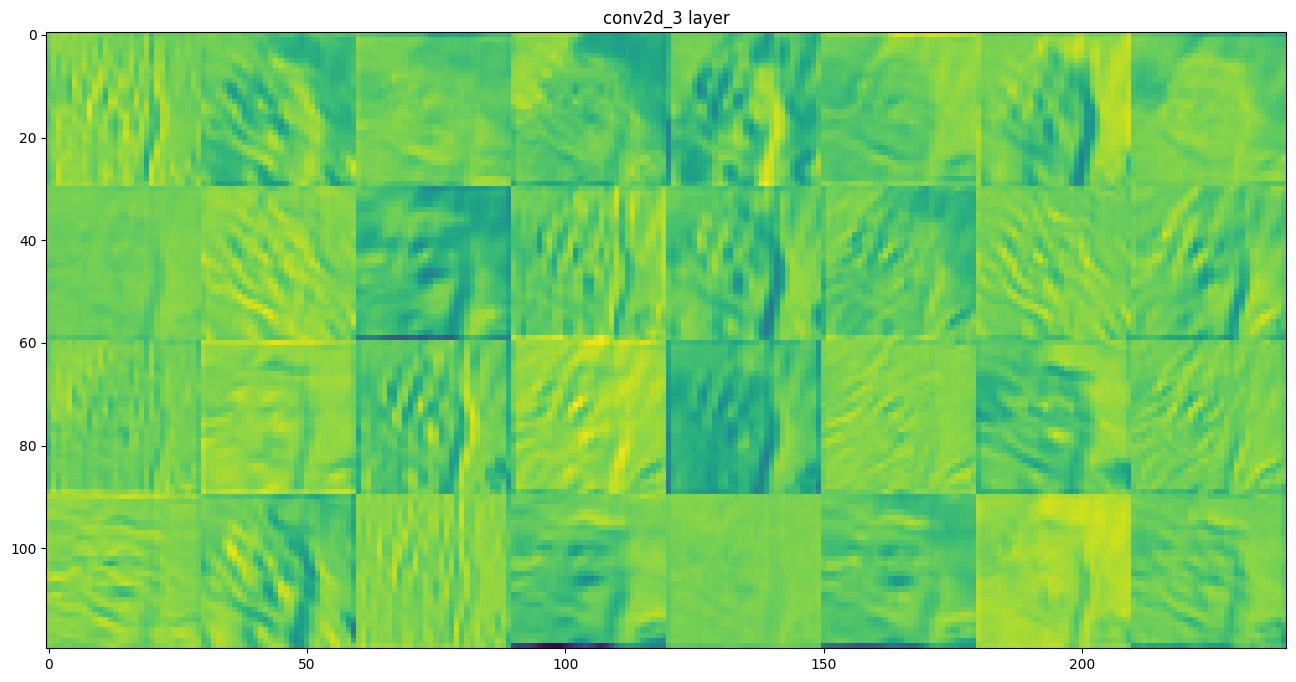

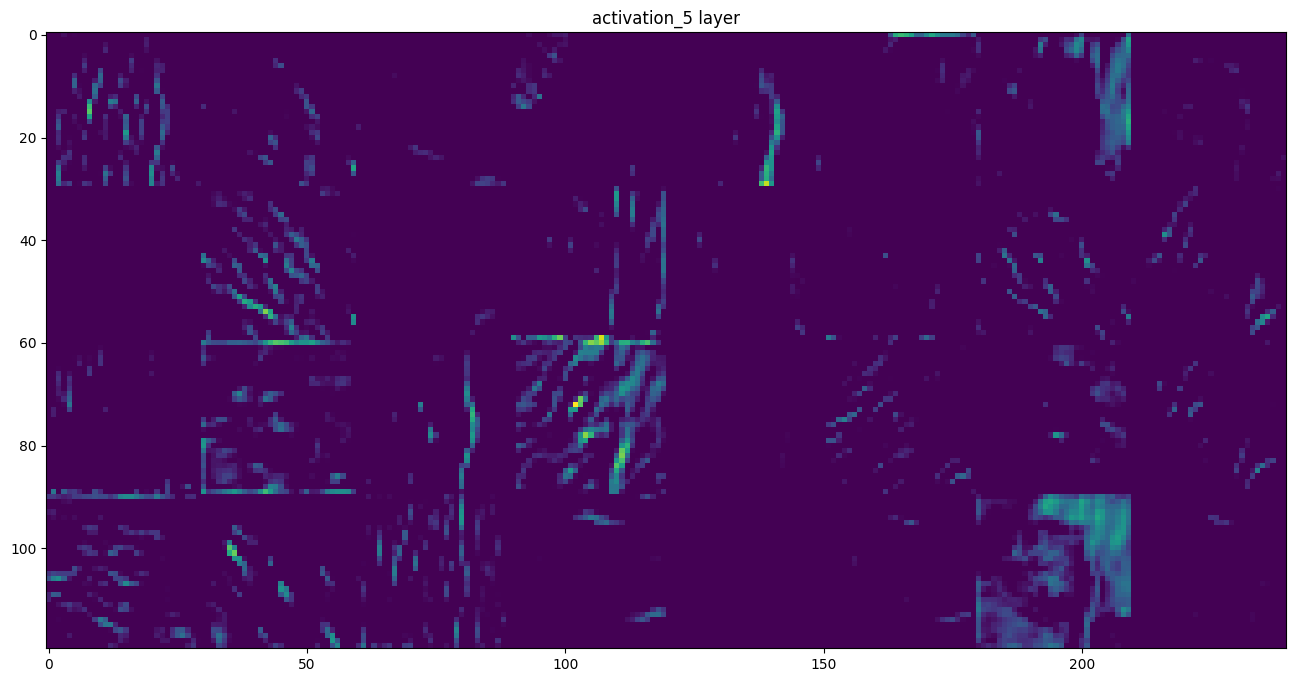

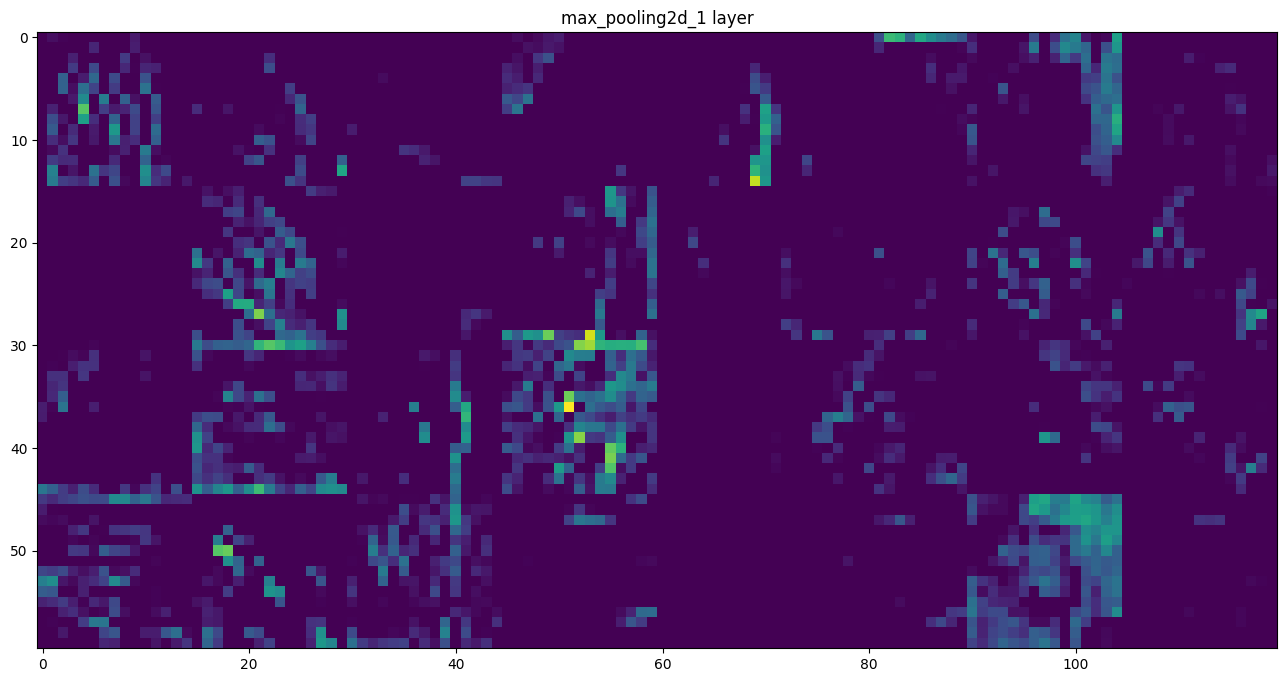

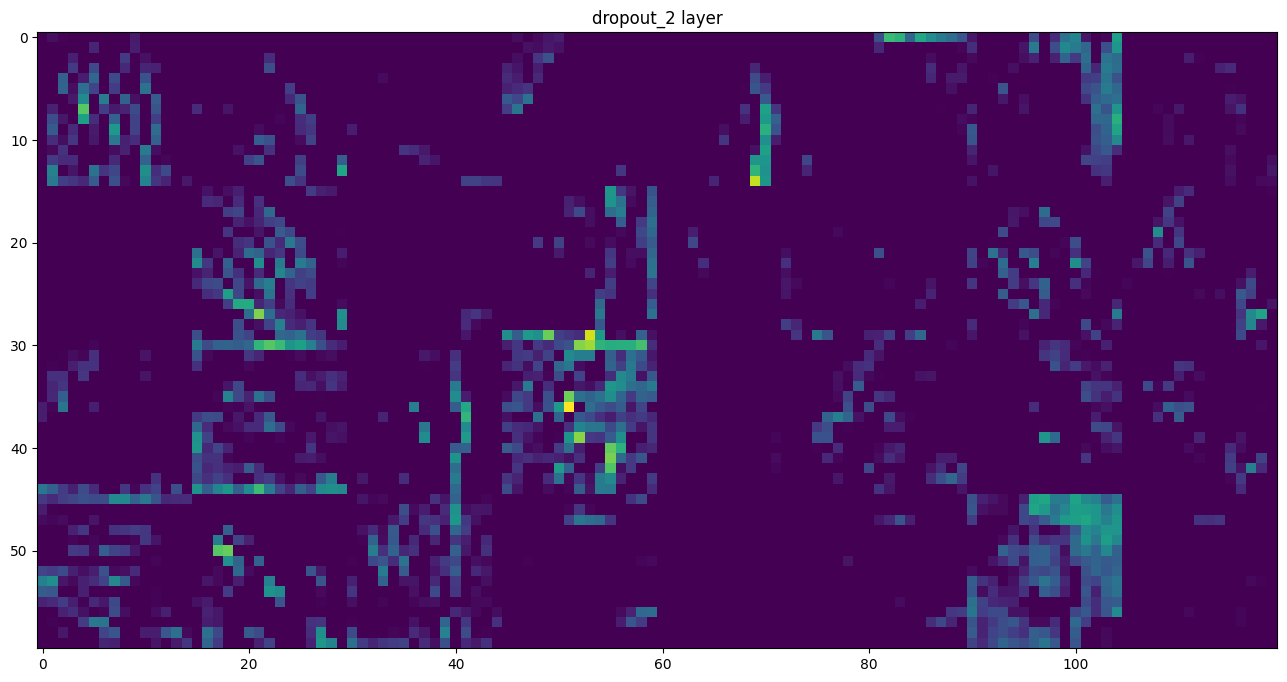

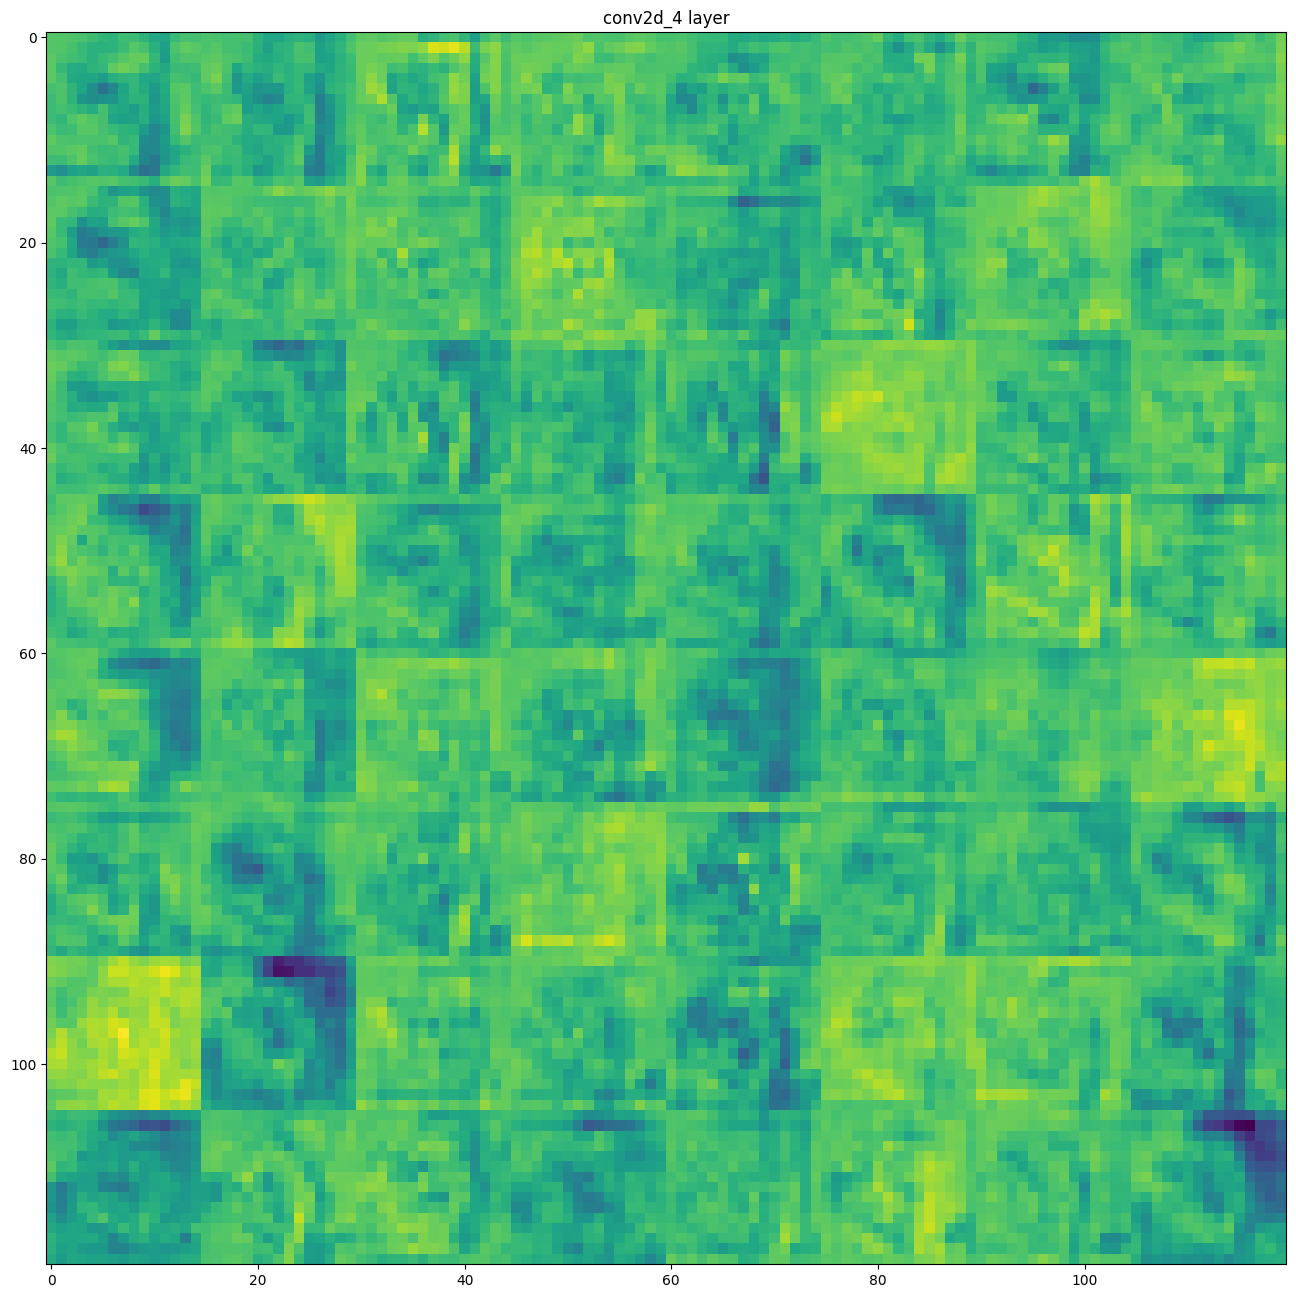

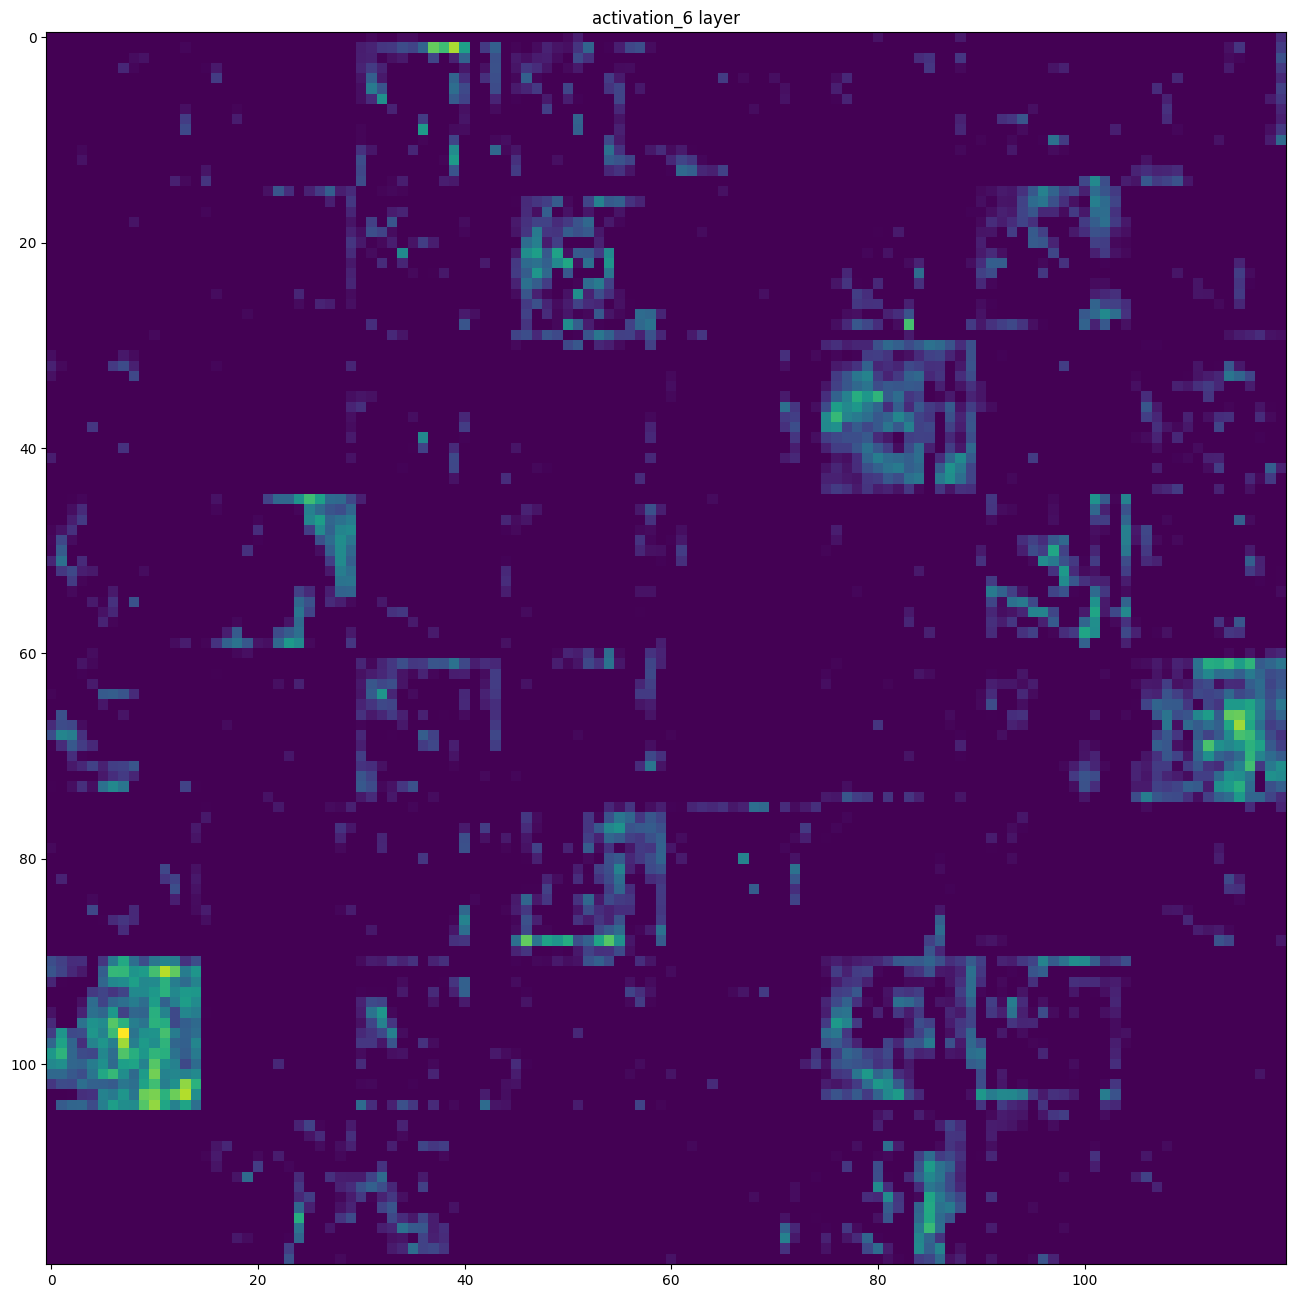

In [53]:
layer_outputs = [layer.output for layer in model_2.layers] 
activation_model = Model(inputs=model_2.input, outputs=layer_outputs) 
activations = activation_model.predict(img_tensor)

plot_activations_multilayer(8, 8, model_2, activations)

1/1 [==============================] - 0s 24ms/step


Text(0.5, 1.0, 'Predicted class is: Dog')

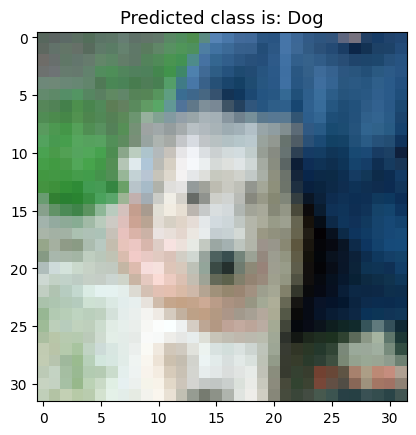

In [54]:
class_names=['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
y = model_2.predict(img_tensor)
label = class_names[np.argmax(y)]
plt.imshow(img_tensor.reshape((32,32,3)).astype("uint8"))
plt.title(f"Predicted class is: {label}", fontsize=13)